In [1]:
import mezo
import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import scipy
import scipy.sparse as ss
from scipy.sparse import linalg as sl
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

### Good Resources
- [Notes by László Oroszlány](http://oroszl.web.elte.hu/mezo/OL_lecture_notes-1.pdf)
- [Non Equilibrium Green’s Functions for Dummies](https://arxiv.org/pdf/cond-mat/0210519.pdf)
- [Green’s Functions in Quantum Physics, E.N. Economou (Springer, 2005)]()
- [Theory of Quantum Transport at Nanoscale, Dmitry A. Ryndyk Chapter 3. (Springer, 2016)]()

## Task: BHZ model dirty edge local density
The Hamiltonian is
$$
\hat H_{BHZ} = \begin{bmatrix}
\hat H_{QWZ} & 0 \\
0 & \hat H^{\dagger}_{QWZ}
\end{bmatrix}.
$$
In QWZ, we have
$$
\hat T_{x/y} = \frac{\hat\sigma_z + i\hat\sigma_{x/y}}{2}, \hat U = \Delta\hat\sigma_z
$$
My tasks:
- Calculate the site resolved local density of states for a BHZ wire with a scatterer located at the edge of the sample.
- Take simple potetial scattering i.e. $V\propto I_4$
- Take completely random scatterer.

The on-site Hamiltonian for a single site is
$$
\hat H_0 = 
\begin{bmatrix}
\Delta\sigma_z & 0 \\
0 & \Delta\sigma_z
\end{bmatrix},
$$
the hopping elements are
$$
\hat H_{1,x/y} = 
\begin{bmatrix}
T_{x/y} & 0 \\
0 & T^{\dagger}_{x/y}
\end{bmatrix}
$$


The Hamiltonian for one column of the scattering region is
$$
\hat H_0^{\mathrm{col}} = 
\begin{bmatrix}
\ddots &                        &                         &                        &               & \\
       & \hat H_0               &  \hat H_{1,y}           &                        &               & \\
       & \hat H^{\dagger}_{1,y} &  \hat H_0               & \hat H_{1,y}           &               & \\
       &                        &  \hat H^{\dagger}_{1,y} & \hat H_0               & \hat H_{1,y}  & \\
       &                        &                         & \hat H^{\dagger}_{1,y} & \hat H_0      & \\
       &                        &                         &                        &               & \ddots
\end{bmatrix}
$$

The Hamiltonian for the full scattering region is 
$$
\hat H^{S} = 
\begin{bmatrix}
\ddots &                       &                       &                       &                       &\\
       &\hat H_0^{\mathrm{col}}&\hat H_{1,cc}          &                       &                       &\\
       &\hat H^{\dagger}_{1,cc}&\hat H_0^{\mathrm{col}}&\hat H_{1,cc}          &                       &\\
       &                       &\hat H^{\dagger}_{1,cc}&\hat H_0^{\mathrm{col}}&\hat H_{1,cc}          &\\
       &                       &                       &\hat H^{\dagger}_{1,cc}&\hat H_0^{\mathrm{col}}&\\
       &                       &                       &                       &                       &\ddots
\end{bmatrix},
$$
where $\hat H_{1,cc}$ denotes the column-to-column hopping matrix:
$$
\hat H_{1,cc} =
\begin{bmatrix}
\ddots &            &            &            &            &\\
       &\hat H_{1,x}&            &            &            &\\
       &            &\hat H_{1,x}&            &            &\\
       &            &            &\hat H_{1,x}&            &\\
       &            &            &            &\hat H_{1,x}&\\
       &            &            &            &            &\ddots
\end{bmatrix}
$$

To calculate the surface Green's function for the scattering region only, we have to solve
$$
\hat G_{S} = \left(E\hat I - \hat H_S\right)^{-1}
$$

The inverse of the Green function of the full system, including the leads is

$$
\begin{align*}
\hat G^{-1} = 
\begin{bmatrix}
(\mathtt{L.gsL})^{-1}     & -\hat H_{1,cc}           &               \\
-\hat H_{1,cc}^{\dagger } & \hat H^S                 & -\hat H_{1,cc} \\
                          & -\hat H_{1,cc}^{\dagger} & (\mathtt{L.gsR})^{-1}
\end{bmatrix}
\end{align*}
$$

The density of states is
$$
\mathrm{DOS} = \sum\limits_{\sigma}\frac{1}{\pi}\mathrm{Im}\{G(\mathbf{r}, \mathbf{r}, \sigma, \sigma)\},
$$
where $\sigma$ denotes the internal degrees of freedom.

In [2]:
s0 = np.array([[1., 0.], [0., 1.]])
sx = np.array([[0., 1.], [1., 0.]]) 
sy = np.array([[0., -1.0j], [1.0j, 0.]])
sz = np.array([[1., 0.], [0., -1.]])

Ty = 0.5*(sz+1j*sy)
Tx = 0.5*(sz+1j*sx)

# On-site Hamiltonian
H0 = ss.kron(s0, sz)

# x hopping
H1x = ss.bmat([[Tx, None], 
               [None, Tx.T.conj()]])

# y hopping
H1y = ss.bmat([[Ty, None], 
               [None, Ty.T.conj()]])

In [3]:
def get_H0_col(nrows, Delta):
    """
    Calculate the Hamiltonian for a single column without random noise
    """
    H0col = ss.kron(np.eye(nrows), Delta*H0)\
    + ss.kron(np.diag(np.ones(nrows-1), 1), H1y)\
    + ss.kron(np.diag(np.ones(nrows-1), -1), H1y.T.conj())
    return H0col

def get_H0_col_dirty(nrows, Delta, rows_dirty_from, rows_dirty_to, use_full_mtx, scale):
    """
    Calculate the Hamiltonian for single column with noises
    """
    H0col = ss.kron(np.eye(nrows), Delta*H0)\
    + ss.kron(np.diag(np.ones(nrows-1), 1), H1y)\
    + ss.kron(np.diag(np.ones(nrows-1), -1), H1y.T.conj())\
    + ss.block_diag([np.random.normal(loc=0.0, scale=scale, size=(4,4)) if use_full_mtx and rows_dirty_from<=k<rows_dirty_to
                     else np.diag(np.random.normal(loc=0.0, scale=scale, size=4)) if rows_dirty_from<=k<rows_dirty_to
                     else np.eye(4)
                     for k in range(nrows)])
    return H0col

def get_H1_cc(nrows):
    """
    Calculate the column-to-column Hamiltonian without noise factor
    """
    return ss.kron(np.eye(nrows), H1x)

def get_HS(nrows, ncols, Delta):
    """
    Calculate the Hamiltonian for the scattering region, without noise
    """
    H0col = get_H0_col(nrows, Delta)
    H1cc = get_H1_cc(nrows)
    HS = ss.kron(np.eye(ncols), H0col)\
    + ss.kron(np.diag(np.ones(ncols-1), 1), H1cc)\
    + ss.kron(np.diag(np.ones(ncols-1), -1), H1cc.T.conj())
    return HS

def get_HS_dirty(nrows, ncols, Delta, dirty_region, use_full_mtx, scale, random_state=None):
    """
    Create a scattering region with a few dirty rows. These have an additional
    on-site potential that is a random diagonal matrix.
    """
    if random_state != None:
        np.random.seed(random_state)
        
    # The dirty region is from the i0th row, j0th column to the i1st row to j1st column
    i0, j0, i1, j1 = dirty_region
    if i0>i1 or j0>j1:
        raise ValueError("i0<i1 and j0<j1 condition not met!")
    
    H0col_clean = get_H0_col(nrows, Delta)
    
    H1cc = get_H1_cc(nrows)
    HS = ss.block_diag([get_H0_col_dirty(nrows, Delta, i0, i1, use_full_mtx, scale) if j0<=k<j1 else H0col_clean for k in range(ncols)])\
    + ss.kron(np.diag(np.ones(ncols-1), 1), H1cc)\
    + ss.kron(np.diag(np.ones(ncols-1), -1), H1cc.T.conj())
    return HS

In [4]:
def plot_system(HS, nrows, ncols):
    diags = np.diag(np.abs(HS.toarray()))
    diags_reduced = [] # Each entry in this array will be associated with a single site
    it = iter(diags)
    while True:
        try:
            diags_reduced.append( np.sum([next(it) for k in range(4)]) )
        except StopIteration:
            break
    diags_reduced = np.array(diags_reduced)
    
    # Build the matrix that corresponds to the system of nrow, ncols shape
    it = iter(diags_reduced)
    sys = np.zeros(shape=(nrows, ncols))
    for i in range(ncols):
        for j in range(nrows):
            sys[j,i] = next(it)

    plt.figure(dpi=96)
    plt.matshow( sys )
    plt.colorbar()

<Figure size 576x384 with 0 Axes>

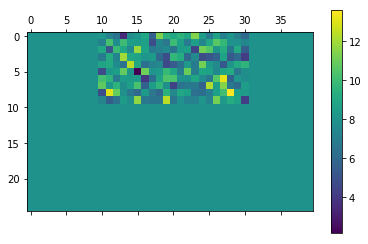

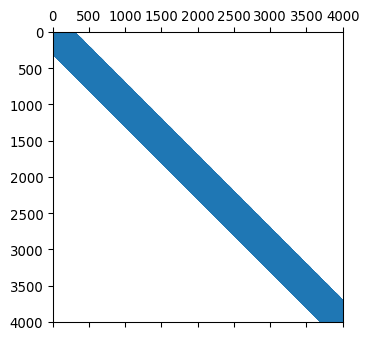

In [7]:
nrows = 25
ncols = 40
dirty_region = (0, 10, 10, 31)

HS = get_HS_dirty(nrows=nrows, ncols=ncols, Delta=-2.0, dirty_region=dirty_region, use_full_mtx=False, scale=1.0, random_state=42)
plot_system(HS, nrows=nrows, ncols=ncols)

plt.figure(dpi=96)
plt.spy(HS)

In [9]:
nrows = 25
ncols = 40
dirty_region = (0, 10, 10, 31)

def plot_scattering_region(Delta, E, random_scale, random_state=None):
    HS = get_HS_dirty(nrows, ncols, Delta, dirty_region=dirty_region, use_full_mtx=False, scale=random_scale, random_state=random_state)

    Heff = E*ss.eye(HS.shape[0]) - HS
    Heff = Heff.tocsc() # CSC format improves efficiency

    # Calculate the surface Greens function
    print("Inverting Heff...")
    GS = sl.inv(Heff)
    print("Successfully inverted Heff.")

    # Extract the system from G
    dof = 4 # we have 4 degrees of freedom on each site
    diags = np.diag(np.imag(GS.toarray())) # Each site corresponds to 4 diagonal elements
    diags_reduced = [] # Each entry in this array will be associated with a single site
    it = iter(diags)
    while True:
        try:
            diags_reduced.append( np.sum([next(it) for k in range(dof)]) )
        except StopIteration:
            break
    diags_reduced = np.array(diags_reduced)

    # Build the matrix that corresponds to the system of nrow, ncols shape
    it = iter(diags_reduced)
    sys = np.zeros(shape=(nrows, ncols))
    for i in range(ncols):
        for j in range(nrows):
            sys[j,i] = next(it)
            
    plt.figure(figsize=(12, 8), dpi=112)
    plt.matshow( sys )
    plt.colorbar();
    plt.title("Delta = {}\n E = {}\n random_scale = {}\n".format(Delta, E, random_scale))
    plt.pause(0.0001)
    return
    
interact(
    plot_scattering_region,
    Delta=widgets.FloatSlider(min=-3, max=3, step=0.1, value=-2),
    E=widgets.FloatSlider(min=-3, max=3, step=0.1, value=-0.0),
    random_scale=widgets.FloatSlider(min=0.0, max=3.0, step=0.1, value=0.0),
    random_state=fixed(42)
)

interactive(children=(FloatSlider(value=-2.0, description='Delta', max=3.0, min=-3.0), FloatSlider(value=-0.0,…

<function __main__.plot_scattering_region(Delta, E, random_scale, random_state=None)>

Inverting Heff...
Successfully inverted Heff.


<Figure size 1344x896 with 0 Axes>

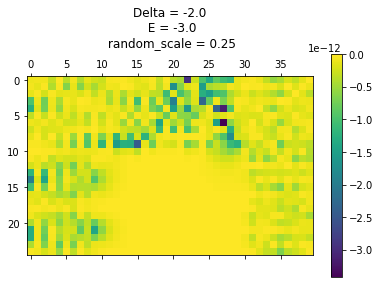

Inverting Heff...
Successfully inverted Heff.


<Figure size 1344x896 with 0 Axes>

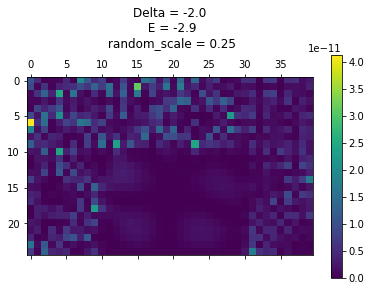

Inverting Heff...
Successfully inverted Heff.


<Figure size 1344x896 with 0 Axes>

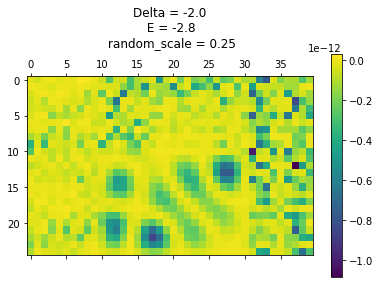

Inverting Heff...
Successfully inverted Heff.


<Figure size 1344x896 with 0 Axes>

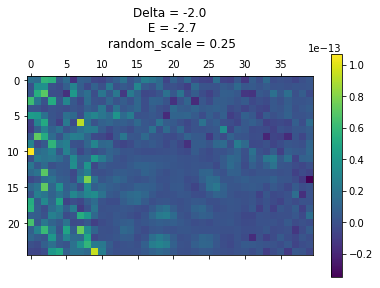

Inverting Heff...
Successfully inverted Heff.


<Figure size 1344x896 with 0 Axes>

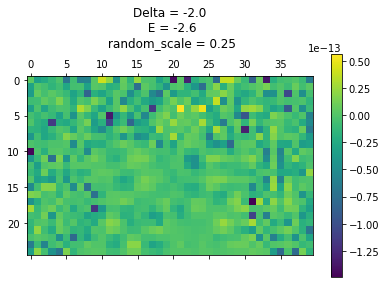

Inverting Heff...
Successfully inverted Heff.


<Figure size 1344x896 with 0 Axes>

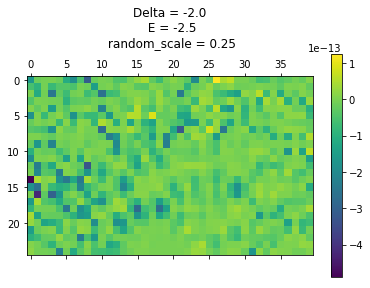

Inverting Heff...
Successfully inverted Heff.


<Figure size 1344x896 with 0 Axes>

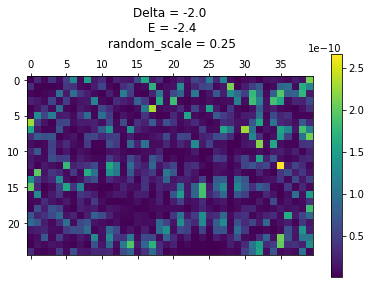

Inverting Heff...
Successfully inverted Heff.


<Figure size 1344x896 with 0 Axes>

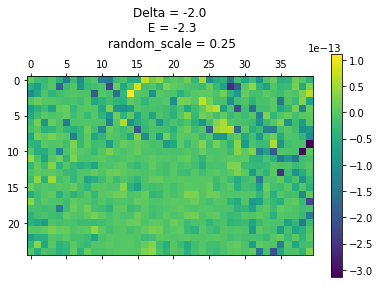

Inverting Heff...
Successfully inverted Heff.


<Figure size 1344x896 with 0 Axes>

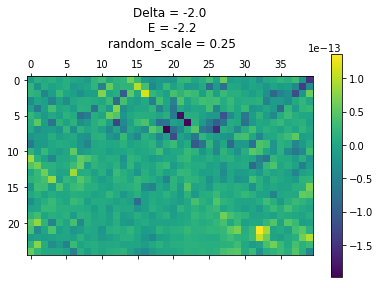

Inverting Heff...
Successfully inverted Heff.


<Figure size 1344x896 with 0 Axes>

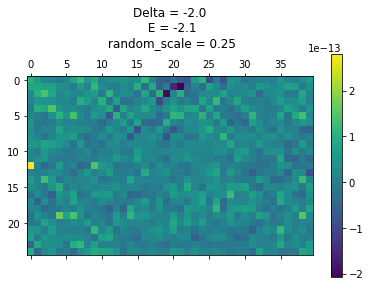

Inverting Heff...
Successfully inverted Heff.


<Figure size 1344x896 with 0 Axes>

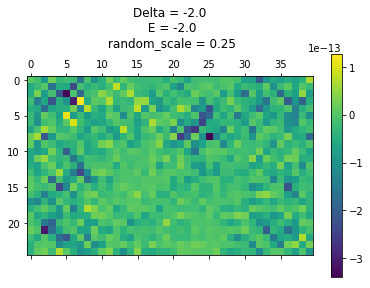

Inverting Heff...
Successfully inverted Heff.


<Figure size 1344x896 with 0 Axes>

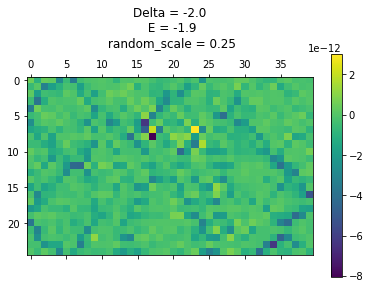

Inverting Heff...
Successfully inverted Heff.


<Figure size 1344x896 with 0 Axes>

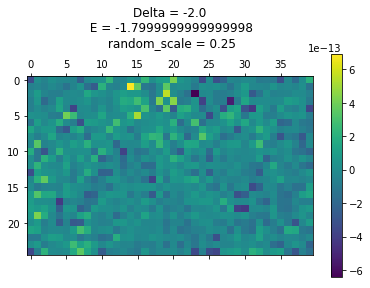

Inverting Heff...
Successfully inverted Heff.


<Figure size 1344x896 with 0 Axes>

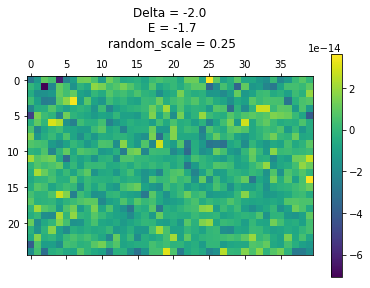

Inverting Heff...
Successfully inverted Heff.


<Figure size 1344x896 with 0 Axes>

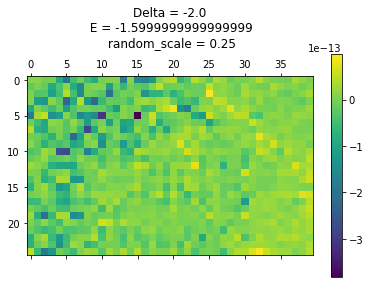

Inverting Heff...
Successfully inverted Heff.


<Figure size 1344x896 with 0 Axes>

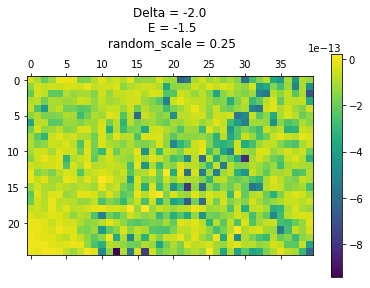

Inverting Heff...
Successfully inverted Heff.


<Figure size 1344x896 with 0 Axes>

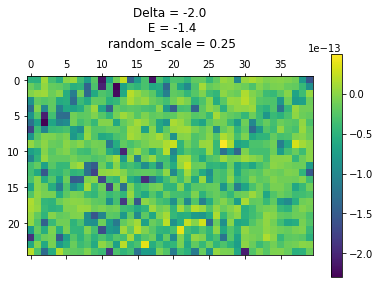

Inverting Heff...
Successfully inverted Heff.


<Figure size 1344x896 with 0 Axes>

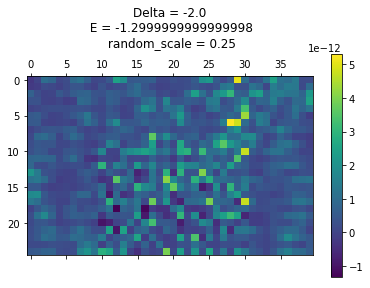

Inverting Heff...
Successfully inverted Heff.


<Figure size 1344x896 with 0 Axes>

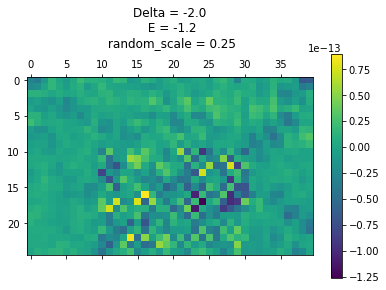

Inverting Heff...
Successfully inverted Heff.


<Figure size 1344x896 with 0 Axes>

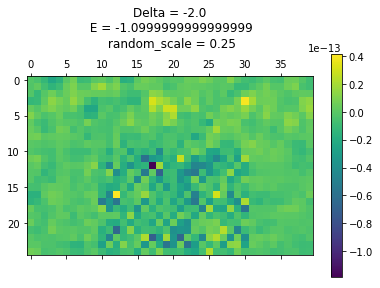

Inverting Heff...
Successfully inverted Heff.


<Figure size 1344x896 with 0 Axes>

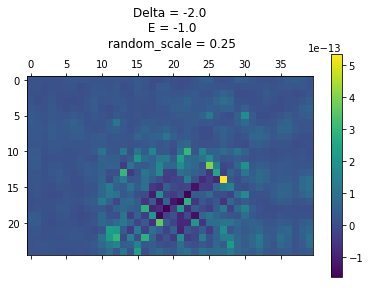

Inverting Heff...
Successfully inverted Heff.


<Figure size 1344x896 with 0 Axes>

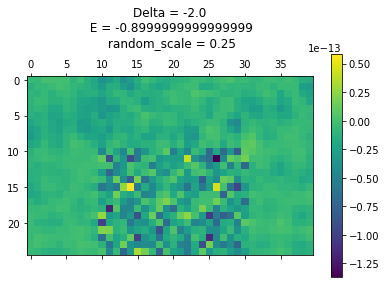

Inverting Heff...
Successfully inverted Heff.


<Figure size 1344x896 with 0 Axes>

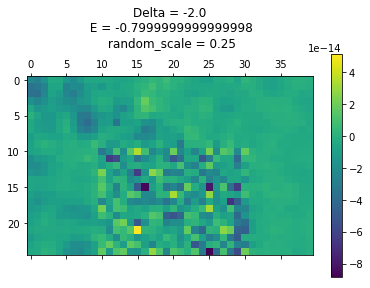

Inverting Heff...
Successfully inverted Heff.


<Figure size 1344x896 with 0 Axes>

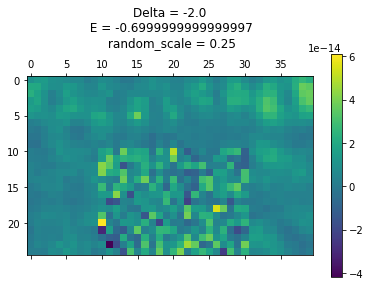

Inverting Heff...
Successfully inverted Heff.


<Figure size 1344x896 with 0 Axes>

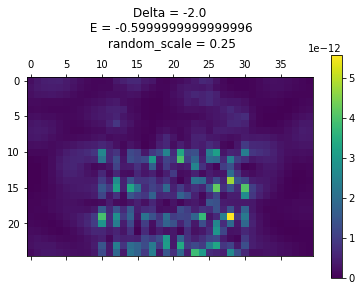

Inverting Heff...
Successfully inverted Heff.


<Figure size 1344x896 with 0 Axes>

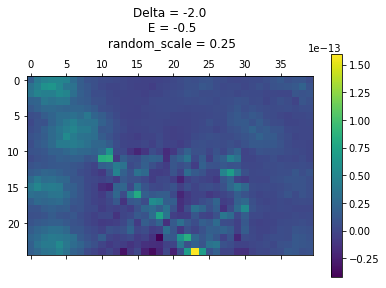

Inverting Heff...
Successfully inverted Heff.


<Figure size 1344x896 with 0 Axes>

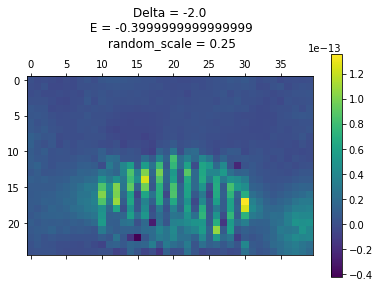

Inverting Heff...
Successfully inverted Heff.


<Figure size 1344x896 with 0 Axes>

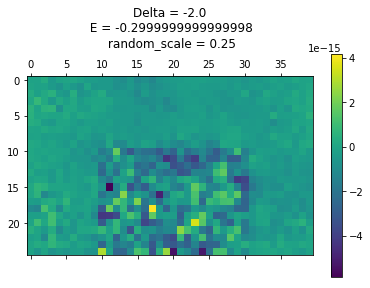

Inverting Heff...
Successfully inverted Heff.


<Figure size 1344x896 with 0 Axes>

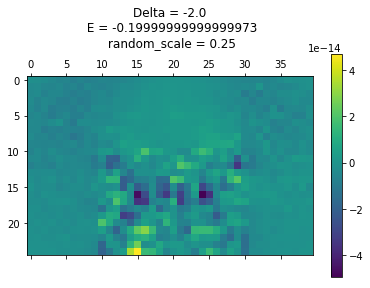

Inverting Heff...
Successfully inverted Heff.


<Figure size 1344x896 with 0 Axes>

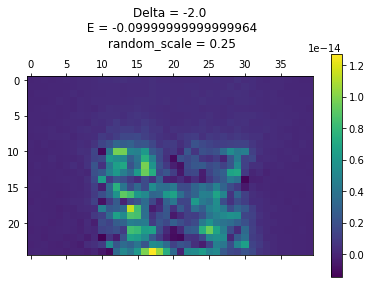

Inverting Heff...
Successfully inverted Heff.


<Figure size 1344x896 with 0 Axes>

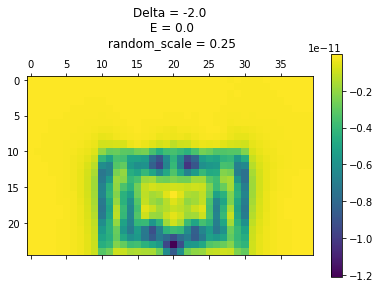

Inverting Heff...
Successfully inverted Heff.


<Figure size 1344x896 with 0 Axes>

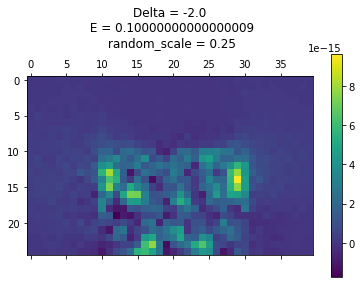

Inverting Heff...
Successfully inverted Heff.


<Figure size 1344x896 with 0 Axes>

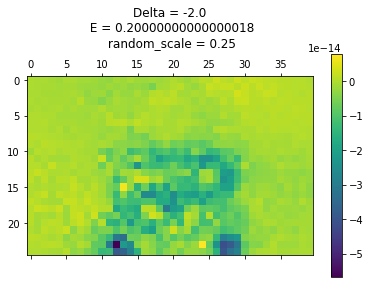

Inverting Heff...
Successfully inverted Heff.


<Figure size 1344x896 with 0 Axes>

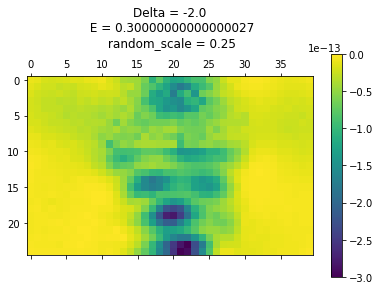

Inverting Heff...
Successfully inverted Heff.


<Figure size 1344x896 with 0 Axes>

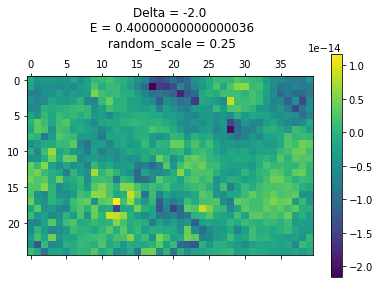

Inverting Heff...
Successfully inverted Heff.


<Figure size 1344x896 with 0 Axes>

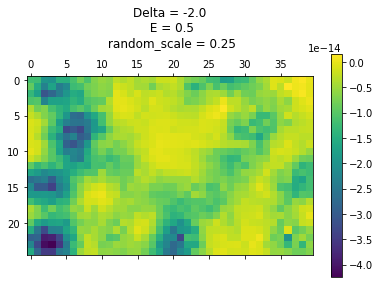

Inverting Heff...
Successfully inverted Heff.


<Figure size 1344x896 with 0 Axes>

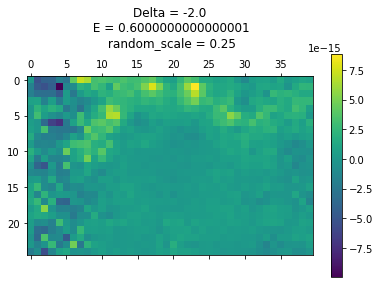

Inverting Heff...
Successfully inverted Heff.


<Figure size 1344x896 with 0 Axes>

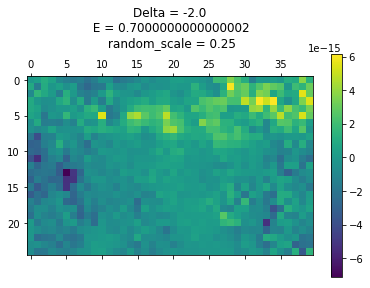

Inverting Heff...
Successfully inverted Heff.


<Figure size 1344x896 with 0 Axes>

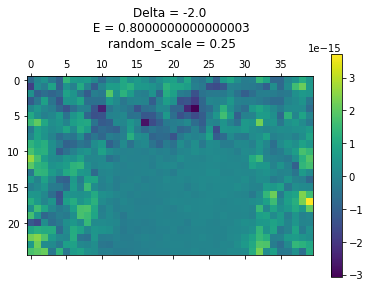

Inverting Heff...
Successfully inverted Heff.


<Figure size 1344x896 with 0 Axes>

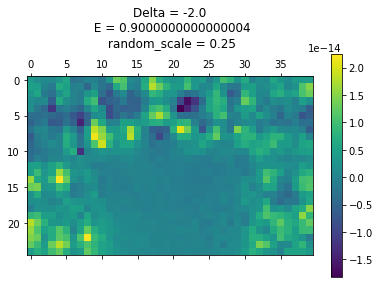

Inverting Heff...
Successfully inverted Heff.


<Figure size 1344x896 with 0 Axes>

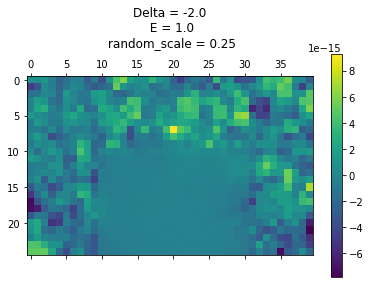

Inverting Heff...
Successfully inverted Heff.


<Figure size 1344x896 with 0 Axes>

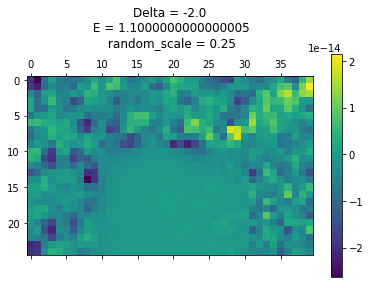

Inverting Heff...
Successfully inverted Heff.


<Figure size 1344x896 with 0 Axes>

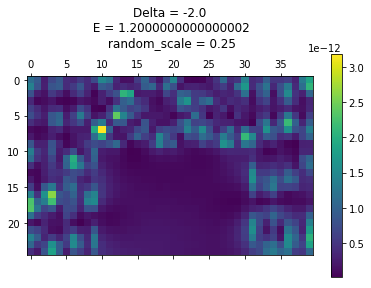

Inverting Heff...
Successfully inverted Heff.


<Figure size 1344x896 with 0 Axes>

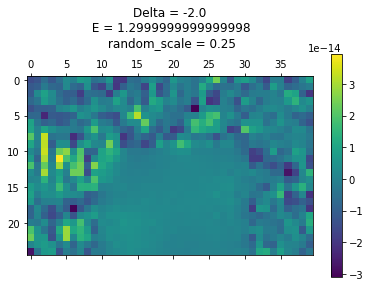

Inverting Heff...
Successfully inverted Heff.


<Figure size 1344x896 with 0 Axes>

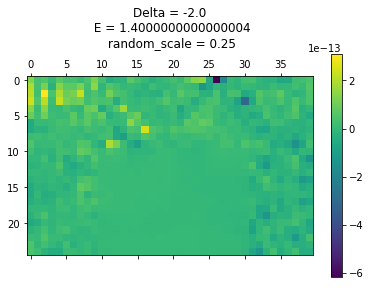

Inverting Heff...
Successfully inverted Heff.


<Figure size 1344x896 with 0 Axes>

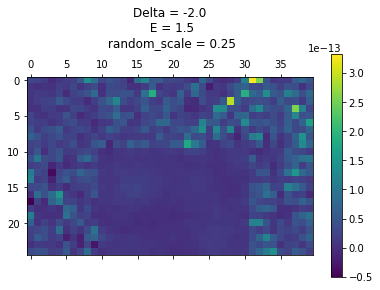

Inverting Heff...
Successfully inverted Heff.


<Figure size 1344x896 with 0 Axes>

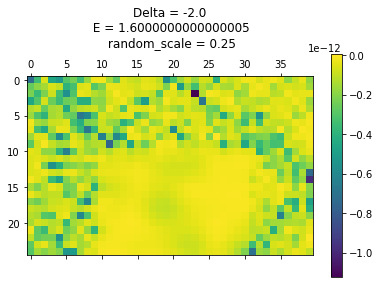

Inverting Heff...
Successfully inverted Heff.


<Figure size 1344x896 with 0 Axes>

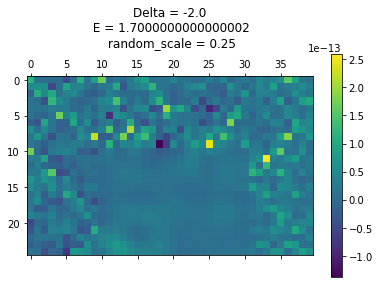

Inverting Heff...
Successfully inverted Heff.


<Figure size 1344x896 with 0 Axes>

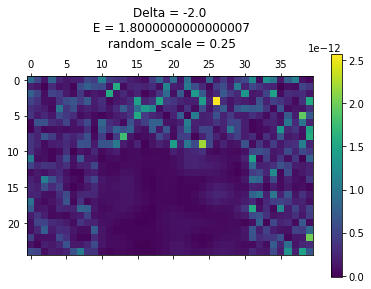

Inverting Heff...
Successfully inverted Heff.


<Figure size 1344x896 with 0 Axes>

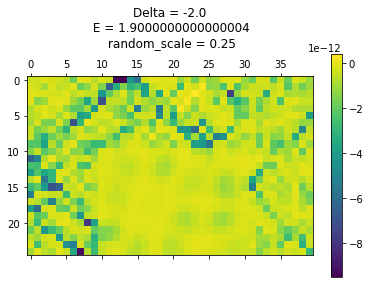

Inverting Heff...
Successfully inverted Heff.


<Figure size 1344x896 with 0 Axes>

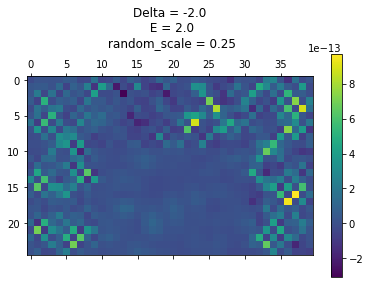

Inverting Heff...
Successfully inverted Heff.


<Figure size 1344x896 with 0 Axes>

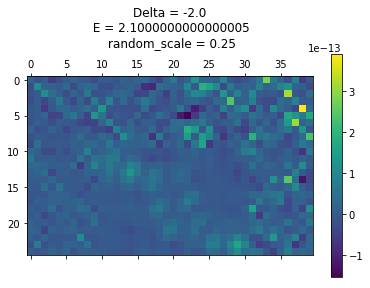

Inverting Heff...
Successfully inverted Heff.


<Figure size 1344x896 with 0 Axes>

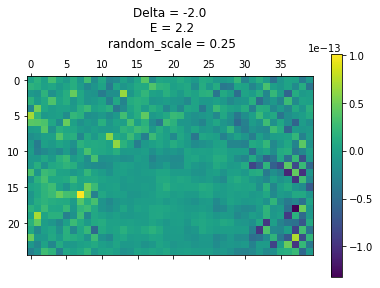

Inverting Heff...
Successfully inverted Heff.


<Figure size 1344x896 with 0 Axes>

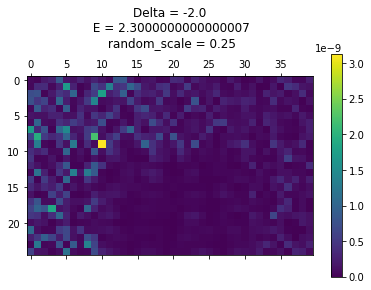

Inverting Heff...
Successfully inverted Heff.


<Figure size 1344x896 with 0 Axes>

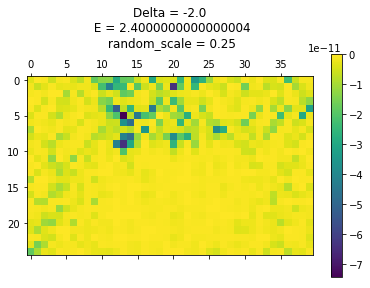

Inverting Heff...
Successfully inverted Heff.


<Figure size 1344x896 with 0 Axes>

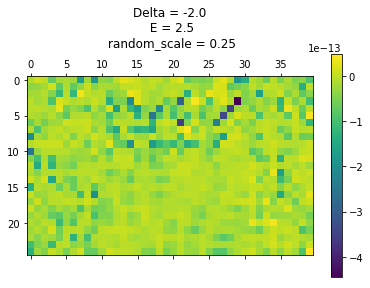

Inverting Heff...
Successfully inverted Heff.


<Figure size 1344x896 with 0 Axes>

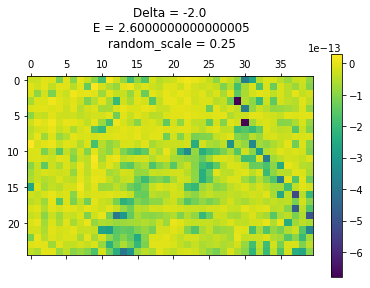

Inverting Heff...
Successfully inverted Heff.


<Figure size 1344x896 with 0 Axes>

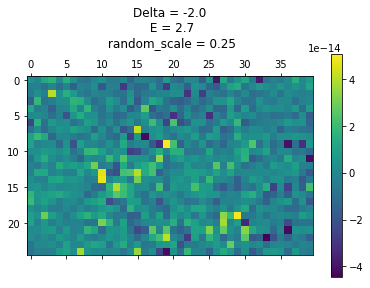

Inverting Heff...
Successfully inverted Heff.


<Figure size 1344x896 with 0 Axes>

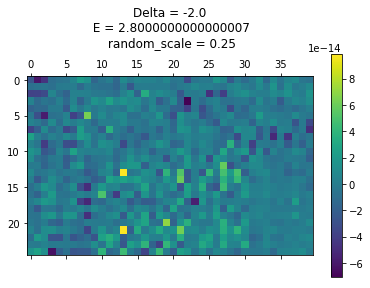

Inverting Heff...
Successfully inverted Heff.


<Figure size 1344x896 with 0 Axes>

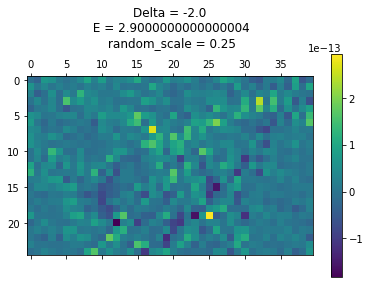

Inverting Heff...
Successfully inverted Heff.


<Figure size 1344x896 with 0 Axes>

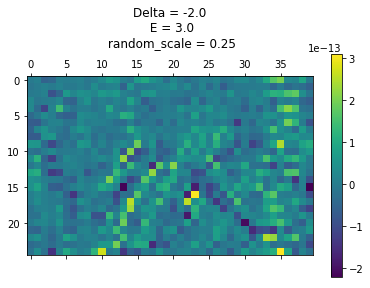

In [10]:
Delta = -2.0
random_scale = 0.25
E = np.linspace(-3.0, 3.0, 61)

for energy in E:
    plot_scattering_region(Delta, energy, random_scale, random_state=42)

### Plot the spectra of $H(\mathbf{k})$.

$$
\begin{equation*}
H(k_x, k_y) = \hat H_0 + \left[e^{ik_x}\hat H_{1,x} + e^{ik_y}\hat H_{1,y} + h.c.\right] \leftarrow\textrm{4x4 hermitian matrix}
\end{equation*}
$$

In [11]:
def H_k(kx, ky, Delta):
    H_k = ss.bmat([[Delta*sz, None], [None, Delta*sz]])\
    + np.exp(1j*kx)*ss.bmat([[Tx, None], [None, Tx.T.conj()]])\
    + np.exp(1j*ky)*ss.bmat([[Ty, None], [None, Ty.T.conj()]])\
    + np.exp(-1j*kx)*ss.bmat([[Tx.T.conj(), None], [None, Tx]])\
    + np.exp(-1j*ky)*ss.bmat([[Ty.T.conj(), None], [None, Ty]])
    return H_k

def H_k_evs(kx, ky, Delta):
    Hk = H_k(kx, ky, Delta)
    evs, _ = sl.eigsh(Hk.toarray())
    return np.array(evs)

/home/dnagy/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1254: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  RuntimeWarning)


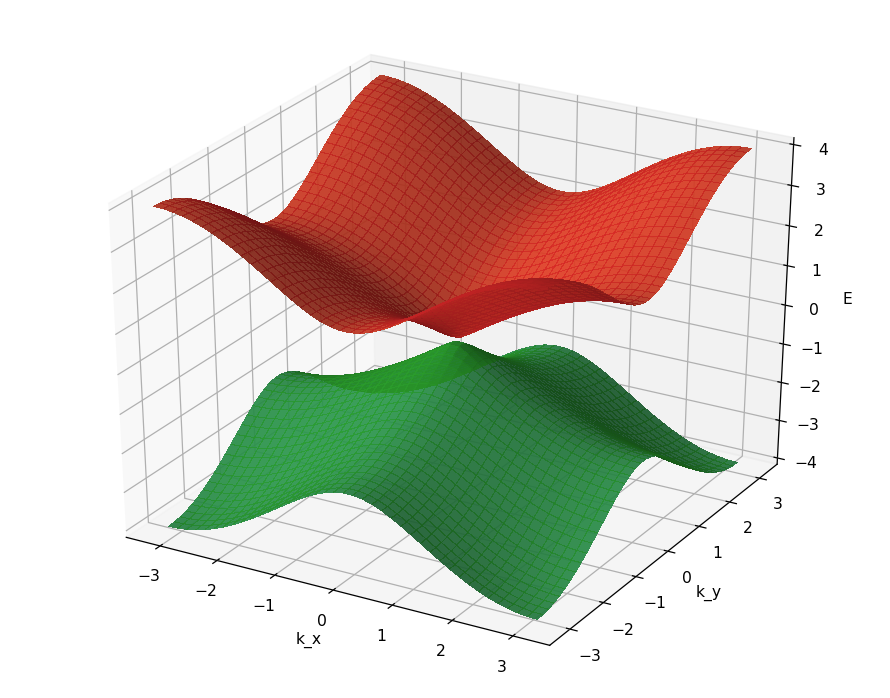

In [12]:
kxrange = np.linspace(-np.pi, np.pi, 40)
kyrange = np.linspace(-np.pi, np.pi, 40)
xs, ys = np.meshgrid(kxrange, kyrange)

def f(x, y):
    return H_k_evs(x, y, Delta=-2.0)
f=np.vectorize(f, otypes=[np.ndarray])

fig = plt.figure(figsize=(10,8), dpi=112)
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("k_x")
ax.set_ylabel("k_y")
ax.set_zlabel("E")

bands = f(xs, ys)
bands = np.array([[ [ev for ev in bands[i, j]] for j in range(bands.shape[1])] for i in range(bands.shape[0])])

for j in range(bands.shape[-1]):
    ax.plot_surface(xs, ys, bands[:,:,j], linewidth=0, antialiased=False, alpha=0.7, label="Band #{}".format(j+1))

##  Attach leads to the scattering region

# Sandbox area

In [ ]:
nA = 3
nB = 2
A = ss.kron(np.eye(nA), 7*sz)
B = ss.kron(np.eye(nB), 2*sz)

In [ ]:
H = ss.bmat([[A, None], [None, B]]).toarray()
H

In [ ]:
LS = np.zeros(shape=(nA+nB, nA+nB))
LS[nA-1,nA]=1
LS[nA,nA-1]=1
LS = ss.kron(LS, 6*sx)
LS.toarray()

In [ ]:
(H+LS)

In [ ]:
plt.spy(H+LS)

In [ ]:
V = 6
nrowsdirty = 2
nrows=5
R1 = ss.kron(np.eye(nrowsdirty), V*s0)
R2 = ss.kron(np.eye(nrows-nrowsdirty), s0)
ss.bmat([[R2, None], [None, R1]]).toarray()

In [ ]:
A = B = 2

In [ ]:
def getA():
    A = 3\
    + 3\
    + 2
    return A

In [ ]:
getA()

In [ ]:
def f(k):
    s,b,x = k
    print(s,b,x)
f(k=(0,2,3))

In [ ]:
dirty_region = (12, 10, 18, 27)
A = np.zeros(shape=(50, 50))
i0, j0, i1, j1 = dirty_region

for row in range(i0, i1):
    for col in range(j0, j1):
        A[row, col] = 1.0
        
plt.matshow(A)

In [ ]:
ss.block_diag([sz,1.2*sz]).toarray()

In [ ]:
X = np.arange(5)
Y = np.arange(5)
X, Y = np.meshgrid(X, Y)
def f(x, y):
    return np.array([x*y*a for a in np.linspace(0.5, 2.0, 3)])
f = np.vectorize(f, otypes=[np.ndarray])

f(X, Y).shape

A = f(X, Y)
A = np.array([[ [ev for ev in A[i, j]] for j in range(A.shape[1])] for i in range(A.shape[0])])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X, Y, A[:,:,0], linewidth=0, antialiased=False, alpha=0.75)
ax.plot_surface(X, Y, A[:,:,1], linewidth=0, antialiased=False, alpha=0.75)
ax.plot_surface(X, Y, A[:,:,2], linewidth=0, antialiased=False, alpha=0.75)

In [ ]:
def f(x,y,z):
    return x,y,z

interact(f, x=(-1, 1, 0.1), y=3, z=4)